# Exploratory Data Anlysis

According to the [writeup at Kaggle for this dataset][kaggle], each image's width and height are both 48 pixels.
The downloaded dataset has segregated the images as `train` and `test`; within each set, they are further categories into one of the seven expressions:

* Angry
* Disgust
* Fear
* Happy
* Neutral
* Sad
* Surprise

Let's render some samples for analysis.

[kaggle]: https://www.kaggle.com/msambare/fer2013

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

IMG_DIM = (48, 48)
CLASSES = os.listdir(os.path.join(os.curdir, 'train'))
N_CLASSES = len(CLASSES)

def load_images(directory, shuffle=False):
    X = []
    y = []
    
    for i, klass in enumerate(CLASSES):
        for _, _, filenames in os.walk(f'{directory}/{klass}'):
            images = [tf.io.decode_jpeg(tf.io.read_file(f'{directory}/{klass}/{fname}'), channels=3)
                      for fname in filenames]
            X.extend(images)
            y.extend([i] * len(images))
            
    idx = np.arange(len(X))

    if shuffle:
        rng = np.random.default_rng(42)
        rng.shuffle(idx)
        
    return np.array(X)[idx], np.array(y)[idx]

trainX, trainy = load_images('train')
testX, testy = load_images('test')

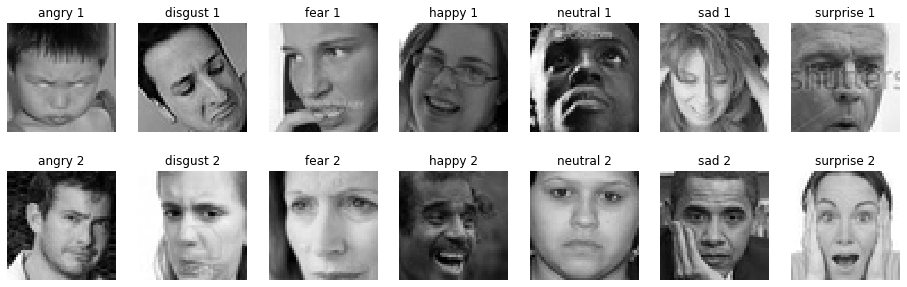

In [2]:
plt.figure(figsize=(16, 5))

for i in range(N_CLASSES):
    for j in range(2):
        plt.subplot(2, 7, i + 1 + j * 7)
        plt.imshow(trainX[trainy == i][j], cmap='binary_r', interpolation='nearest')
        plt.axis('off')
        plt.title(f'{CLASSES[i]} {j + 1}')
    
plt.show()

Even this small sample shows that classification will likely be hard to do:

* Images with Neutral and Sad expressions seem to be interchangable.
* `Angry 2` could be "re-classified" as Neutral (or maybe even Sad).
* `Surprise 2` could also be classified as Happy.

# Training CNN Classifiers
Let's train a custom CNN with Conv2D (those as bottom layers + some Dense layers at the top).
For a start, let's train a shallow-ish model for a quick gauge on the network's performance.

In [3]:
from tensorflow.keras import callbacks, layers, models

def build_conv2d_model(n_convd_layers=1, n_dense_layers=1, n_neurons=50):
    model = models.Sequential([
        layers.InputLayer(input_shape=IMG_DIM + (3,)),
        layers.Rescaling(1./255)
    ])
    
    for i in range(n_convd_layers):
        model.add(layers.Conv2D(filters=32 * (i + 1), kernel_size=3, activation='relu'))
        model.add(layers.MaxPool2D(pool_size=2))
        
    model.add(layers.Flatten())
    
    for _ in range(n_dense_layers):
        model.add(layers.Dense(n_neurons, activation='relu'))
        
    model.add(layers.Dense(N_CLASSES, activation='softmax'))
 
    model.compile(
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
        optimizer='rmsprop'
    )
    
    return model

def make_callbacks():
    return [callbacks.EarlyStopping(monitor='val_loss', patience=5)]


def build_and_train_model(trainX, trainy, n_convd_layers, n_dense_layers, n_neurons):
    model = build_conv2d_model(n_convd_layers=n_convd_layers,
                               n_dense_layers=n_dense_layers,
                               n_neurons=n_neurons)
    
    history = model.fit(trainX, trainy,
                        epochs=50,
                        validation_split=.2,
                        batch_size=32,
                        callbacks=make_callbacks())
    
    return model, history


def plot_training_history(history, title):
    epochs = range(len(history.history['accuracy']))
    plt.figure(figsize=(12, 8))

    for label, representation in zip(history.history.keys(), ['b-', 'g-', 'r-', 'y-']):
        plt.plot(epochs, history.history[label], representation, label=label)
    
    plt.title(title)
    plt.legend()
    plt.show()

In [4]:
model = build_conv2d_model(2, 2, 50)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 48, 48, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6400)              0

Epoch 1/50
718/718 [==============================] - 7s 7ms/step - loss: 1.4972 - accuracy: 0.3964 - val_loss: 8.5684 - val_accuracy: 0.0164
Epoch 2/50
718/718 [==============================] - 5s 6ms/step - loss: 1.2909 - accuracy: 0.4992 - val_loss: 11.8851 - val_accuracy: 0.0132
Epoch 3/50
718/718 [==============================] - 5s 6ms/step - loss: 1.1886 - accuracy: 0.5426 - val_loss: 15.1722 - val_accuracy: 0.0509
Epoch 4/50
718/718 [==============================] - 5s 6ms/step - loss: 1.1045 - accuracy: 0.5756 - val_loss: 16.6055 - val_accuracy: 0.0362
Epoch 5/50
718/718 [==============================] - 5s 6ms/step - loss: 1.0272 - accuracy: 0.6098 - val_loss: 16.9911 - val_accuracy: 0.0477
Epoch 6/50
718/718 [==============================] - 5s 6ms/step - loss: 0.9496 - accuracy: 0.6417 - val_loss: 20.6332 - val_accuracy: 0.1566


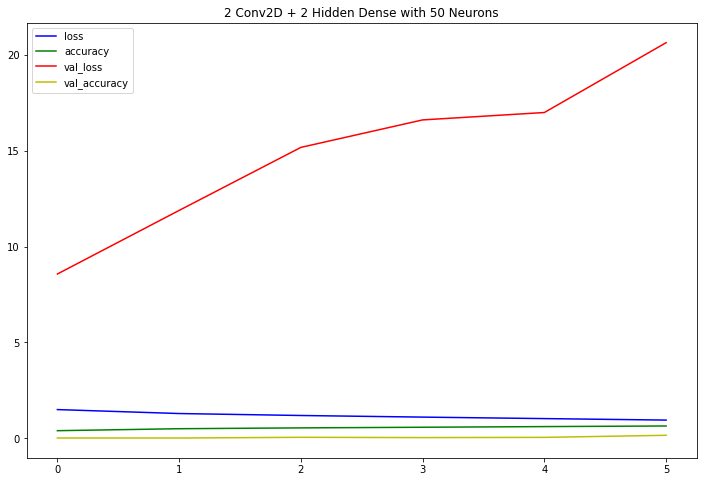

In [5]:
conv2d_model, history = build_and_train_model(trainX, trainy, 2, 2, 50)
plot_training_history(history, '2 Conv2D + 2 Hidden Dense with 50 Neurons')

The custom CNN model doesn't seem too promising. Let's try using a trained model--Xception--and apply transfer learning to determine whether a pretrained model is better.

As [Xception expects the image size to be at least 71x71][xception], the model's initial few layers include resizing and rescaling transformation to the original's 48x48. As we are using transfer learning, we need to exclude the fully-connected layers and freeze the convolutional layers.

[xception]: https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception/Xception#args

In [6]:
from tensorflow.keras.applications import Xception

resized_dim = (IMG_DIM[0] * 2, IMG_DIM[1] * 2)

def build_xception_model(n_dense_layers=2, n_neurons=50):

    xception = Xception(include_top=False, input_shape=resized_dim + (3,), classes=N_CLASSES)
    xception.trainable = False

    model = models.Sequential([
        layers.InputLayer(input_shape=IMG_DIM + (3,)),
        layers.Resizing(resized_dim[0], resized_dim[1]),
        layers.Rescaling(1./255),
        xception,
        layers.Flatten()])
    
    for _ in range(n_dense_layers):
        model.add(layers.Dense(n_neurons, activation='relu'))

    layers.Dense(N_CLASSES, activation='softmax')
    
    model.compile(
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    optimizer='adam')

    return model

In [7]:
xception_model = build_xception_model(2, 50)
xception_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 96, 96, 3)         0         
                                                                 
 rescaling_2 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_6 (Dense)             (None, 50)                921650    
                                                                 
 dense_7 (Dense)             (None, 50)                2550      
                                                                 
Total params: 21,785,680
Trainable params: 924,200
Non

This model has about 900k trainable params; that's about 2.5-3 times more than the custom model above (and that's not counting the frozen Xception parameters). Let's train this and compare its performance with the custom model 

In [8]:
history = xception_model.fit(trainX, trainy, epochs=50, validation_split=.2, batch_size=32, callbacks=make_callbacks())

Epoch 1/50
718/718 [==============================] - 30s 39ms/step - loss: 2.3770 - accuracy: 0.1263 - val_loss: 10.6867 - val_accuracy: 0.4060
Epoch 2/50
718/718 [==============================] - 27s 38ms/step - loss: 2.0051 - accuracy: 0.1432 - val_loss: 10.5093 - val_accuracy: 0.0723
Epoch 3/50
718/718 [==============================] - 27s 38ms/step - loss: 1.9181 - accuracy: 0.1659 - val_loss: 10.5055 - val_accuracy: 0.2283
Epoch 4/50
718/718 [==============================] - 28s 38ms/step - loss: 1.9217 - accuracy: 0.1555 - val_loss: 10.5035 - val_accuracy: 0.2320
Epoch 5/50
718/718 [==============================] - 28s 39ms/step - loss: 1.9195 - accuracy: 0.1647 - val_loss: 10.5066 - val_accuracy: 0.0287
Epoch 6/50
718/718 [==============================] - 28s 38ms/step - loss: 1.9195 - accuracy: 0.1759 - val_loss: 10.5054 - val_accuracy: 0.0561
Epoch 7/50
718/718 [==============================] - 28s 38ms/step - loss: 1.9207 - accuracy: 0.1753 - val_loss: 10.5102 - val_ac

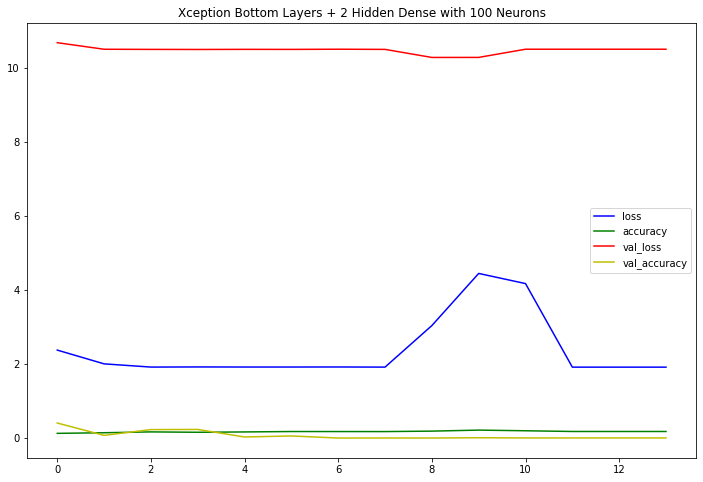

In [9]:
plot_training_history(history, 'Xception Bottom Layers + 2 Hidden Dense with 100 Neurons')

This seems to be worse than the custom CNN model. Let's evaluate both model against the test dataset for comparison.

In [10]:
conv2d_model.evaluate(testX, testy), xception_model.evaluate(testX, testy)

225/225 [==============================] - 7s 31ms/step - loss: 3.7266 - accuracy: 0.1360


([5.31820011138916, 0.46085259318351746],
 [3.7266273498535156, 0.13597102463245392])

Looks like the custom model is still better than Xception's: higher accuracy.